In [1]:
# import pandas as pd 
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np
# from sklearn.model_selection import train_test_split
# X = pd.read_csv('/gdrive/MyDrive/cleaned_training_data_01.csv')
# X['average_delay'] = X['carrier_delay'] + X['nas_delay'] + X['late_aircraft_delay']
# X = X[['crs_arr_time','actual_elapsed_time','distance','year','month','day','weekday','average_delay']]
# y = X['arr_delay']
# reg = RandomForestRegressor(n_estimators=100)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# reg.fit(X_train,y_train)

# y_pred=reg.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# rmse

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [5]:
import pandas as pd 
import numpy as np
from sklearn.utils import shuffle

In [6]:
df = pd.read_csv('/gdrive/MyDrive/Regression_no_outliers_cleaned_data.csv')

In [7]:
df

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,crs_dep_time,dep_time,dep_delay,dest,arr_time,arr_delay,crs_arr_time,crs_elapsed_time,actual_elapsed_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,month,day,weekday
0,2018-03-06,B6,B6,112,ORD,2033,2016.0,-17.0,BOS,2340.0,-10.0,2350,137.0,144.0,867.0,0.0,0.0,0.0,0.0,0.0,2018,3,6,0.0
1,2018-04-28,AA,AA,442,PHX,2005,1956.0,-9.0,SJC,2142.0,-19.0,2201,116.0,106.0,621.0,0.0,0.0,0.0,0.0,0.0,2018,4,28,1.0
2,2019-03-24,B6,B6,1837,BOS,2041,2026.0,-15.0,DTW,2240.0,-7.0,2247,126.0,134.0,632.0,0.0,0.0,0.0,0.0,0.0,2019,3,24,1.0
3,2019-04-28,AA,AA,2790,DFW,2240,2233.0,-7.0,IAH,2330.0,-17.0,2347,67.0,57.0,224.0,0.0,0.0,0.0,0.0,0.0,2019,4,28,1.0
4,2018-09-01,B6,B6,790,DCA,1535,1600.0,25.0,BOS,1718.0,7.0,1711,96.0,78.0,399.0,0.0,0.0,0.0,0.0,0.0,2018,9,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578883,2019-04-12,AS,AS,1039,LAS,600,558.0,-2.0,SEA,915.0,25.0,850,170.0,197.0,867.0,0.0,0.0,25.0,0.0,0.0,2019,4,12,0.0
578884,2019-03-27,UA,OO,5744,LAX,2240,2307.0,27.0,SBA,4.0,29.0,2335,55.0,57.0,89.0,0.0,0.0,2.0,0.0,27.0,2019,3,27,0.0
578885,2018-08-13,AA,AA,588,LGA,559,558.0,-1.0,PHL,714.0,7.0,707,68.0,76.0,96.0,0.0,0.0,0.0,0.0,0.0,2018,8,13,0.0
578886,2018-07-13,UA,UA,1027,ORD,1425,1421.0,-4.0,CHS,1744.0,3.0,1741,136.0,143.0,760.0,0.0,0.0,0.0,0.0,0.0,2018,7,13,0.0


In [8]:
weatherdf = pd.read_csv('/gdrive/MyDrive/weather.csv')

In [9]:
weatherdf = weatherdf[['date','airport_code','visibility','value']]


In [10]:
weatherdf = weatherdf.rename({'date':'fl_date','airport_code':'origin'},axis=1)


In [11]:
df = df.merge(weatherdf, on=['fl_date','origin'])


In [12]:
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [13]:
df['op_unique_carrier'] = df.op_unique_carrier.astype('category').cat.codes.astype('category')
df['origin'] = df.origin.astype('category')
df['dest'] = df.dest.astype('category')
df['visibility'] = df.visibility.astype('category').cat.codes.astype('category')

In [14]:
def crs_dep(row):
  if row['crs_dep_time'] < 0:
    return 2400 + row['crs_dep_time']
  else:
    return row['crs_dep_time']

In [15]:
def value(row):
  if 'snow' in row['value']:
    return 'Snow'
  elif 'rain' in row['value']:
    return 'Rain'
  elif 'showers' in row['value']:
    return 'Rain'
  elif 'possible' in row['value']:
    return 'Rain'
  elif 'drizzle' in row['value']:
    return 'Rain'
  elif 'sleet' in row['value']:
    return 'Rain/Snow'
  elif 'blizzard' in row['value']:
    return 'Snow'
  else:
    return row['value']

In [16]:
df

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,crs_dep_time,dep_time,dep_delay,dest,arr_time,arr_delay,crs_arr_time,crs_elapsed_time,actual_elapsed_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,month,day,weekday,visibility,value
0,2018-03-06,B6,4,112,ORD,2033,2016.0,-17.0,BOS,2340.0,-10.0,2350,137.0,144.0,867.0,0.0,0.0,0.0,0.0,0.0,2018,3,6,0.0,10,Sunny
1,2018-03-06,UA,16,5142,ORD,2059,2059.0,0.0,DLH,2224.0,-5.0,2229,90.0,85.0,397.0,0.0,0.0,0.0,0.0,0.0,2018,3,6,0.0,10,Sunny
2,2018-03-06,AA,13,3552,ORD,2025,2016.0,-9.0,DBQ,2125.0,1.0,2124,59.0,69.0,147.0,0.0,0.0,0.0,0.0,0.0,2018,3,6,0.0,10,Sunny
3,2018-03-06,UA,19,782,ORD,1938,1935.0,-3.0,DFW,2156.0,-10.0,2206,148.0,141.0,802.0,0.0,0.0,0.0,0.0,0.0,2018,3,6,0.0,10,Sunny
4,2018-03-06,AA,1,352,ORD,1830,1854.0,24.0,LGA,2157.0,17.0,2140,130.0,123.0,733.0,9.0,8.0,0.0,0.0,0.0,2018,3,6,0.0,10,Sunny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588122,2018-05-12,AS,2,1351,BOS,650,649.0,-1.0,SFO,1026.0,2.0,1024,394.0,397.0,2704.0,0.0,0.0,0.0,0.0,0.0,2018,5,12,1.0,10,Sunny
588123,2018-05-12,DL,7,1762,BOS,1220,1219.0,-1.0,ATL,1445.0,-20.0,1505,165.0,146.0,946.0,0.0,0.0,0.0,0.0,0.0,2018,5,12,1.0,10,Sunny
588124,2018-01-04,DL,7,1879,LGA,705,705.0,0.0,FLL,1027.0,2.0,1025,200.0,202.0,1076.0,0.0,0.0,0.0,0.0,0.0,2018,1,4,0.0,8,Light snow
588125,2018-03-21,B6,4,632,LGA,900,859.0,-1.0,BOS,1004.0,-28.0,1032,92.0,65.0,184.0,0.0,0.0,0.0,0.0,0.0,2018,3,21,0.0,10,Partly cloudy


In [17]:
X,y = df.drop('arr_delay',axis=1),df['arr_delay']

In [18]:
X['crs_dep_time'] = X['crs_arr_time'] - X['crs_elapsed_time']


In [19]:
X['crs_dep_time'] = X.apply(crs_dep,axis=1)


In [20]:
X['value'] = X.apply(value,axis=1)
X['value'] = X.value.astype('category').cat.codes.astype('category')



In [21]:
X['crs_dep_time'] = X['crs_dep_time'].astype(float).astype(int).apply(lambda x: '{0:0>4}'.format(x)).astype(str)

In [22]:
X['crs_arr_hour'] = X['crs_arr_time'].astype(str).str[:2].astype(int)

X['crs_dep_hour'] = X['crs_dep_time'].astype(str).str[:2].astype(int)


In [23]:
X['Numerical_Week']= (pd.to_datetime(X['fl_date']).dt.weekofyear)
X['Season']= (pd.to_datetime(X['fl_date']).dt.month - 1) // 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [24]:
X['Weekday'] = pd.to_datetime(X['fl_date']).dt.dayofweek

In [25]:
X['sumDelays'] = X['carrier_delay']+	X['weather_delay'] + 	X['nas_delay']+ X['security_delay']+ 	X['late_aircraft_delay']
X['meanOfGrouping'] = X.groupby(['origin','dest','Numerical_Week','crs_arr_hour'])['sumDelays'].transform('mean')
X= X.drop(['sumDelays'], axis=1)


In [66]:
mergeToTest = X[['origin','dest','Numerical_Week','crs_arr_hour','meanOfGrouping']]

In [27]:
X= X.drop(['fl_date','mkt_unique_carrier','carrier_delay','day','dep_delay','dep_time','Season',	'actual_elapsed_time','weather_delay', 	'nas_delay', 	'security_delay', 'late_aircraft_delay'],axis=1)
X = X.drop(['year','crs_arr_time'],axis=1)
X = X.drop(['weekday','visibility','crs_dep_time','op_carrier_fl_num','arr_time'],axis=1)

In [28]:
# X = X.drop(['crs_dep_time','origin','dest','op_unique_carrier','day','year','dep_time','arr_time','sumDelays','crs_arr_time','weekday'],axis=1)

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score 
from sklearn.model_selection import GridSearchCV
import xgboost as xg

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
model = RandomForestRegressor()

In [34]:
# model.fit(X_train,y_train)
# y_pred = model.predict(X_test)
# model.score(X_test,y_test)

In [35]:
#print('mean_squared_error:', mean_squared_error(y_test,y_pred))
#print('RSME:',np.sqrt(mean_squared_error(y_test, y_pred)))
#print('r2 score:', r2_score(y_test,y_pred))
#print('Adjusted R2 value:', 1 - (1-model.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

In [36]:
# model = GradientBoostingRegressor(n_estimators=150,learning_rate=1.5,random_state=1)
# model.fit(X_train,y_train)
# y_pred = model.predict(X_test)

In [37]:
# print('mean_squared_error:', mean_squared_error(y_test,y_pred))
# print('RSME:',np.sqrt(mean_squared_error(y_test, y_pred)))
# print('r2 score:', r2_score(y_test,y_pred))
# print('Adjusted R2 value:', 1 - (1-model.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

In [38]:
import xgboost as xgb

In [39]:
X.columns

Index(['op_unique_carrier', 'origin', 'dest', 'crs_elapsed_time', 'distance',
       'month', 'value', 'crs_arr_hour', 'crs_dep_hour', 'Numerical_Week',
       'Weekday', 'meanOfGrouping'],
      dtype='object')

In [40]:
# xgbr = xgb.XGBRegressor(n_estimators =200,random_state=12) 
# xgbr.fit(X_train,y_train)
# y_pred = xgbr.predict(X_test)
# xgbr.score(X_test,y_test)

In [41]:
# print('mean_squared_error:', mean_squared_error(y_test,y_pred))
# print('RSME:',np.sqrt(mean_squared_error(y_test, y_pred)))
# print('r2 score:', r2_score(y_test,y_pred))
# print('Adjusted R2 value:', 1 - (1-xgbr.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

In [42]:
import lightgbm

In [43]:
model = lightgbm.LGBMRegressor(n_estimators=100,random_state=12)

In [44]:
model.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [45]:
y_pred = model.predict(X_test)

In [46]:
X_test

,op_unique_carrier,origin,dest,crs_elapsed_time,distance,month,value,crs_arr_hour,crs_dep_hour,Numerical_Week,Weekday,meanOfGrouping
77116,13,DFW,LRD,79.0,396.0,9,6,18,17,36,0,0.0
271345,21,CLT,MDW,115.0,584.0,6,6,70,5,23,2,0.0
388160,7,DEN,MSP,122.0,680.0,2,5,14,13,8,2,32.2
399368,7,CLT,MSP,170.0,930.0,4,5,95,7,17,1,0.0
233863,7,LGA,MSP,177.0,1020.0,9,5,93,7,38,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
116107,1,PHX,DEN,114.0,602.0,1,9,15,14,4,2,0.0
471777,7,ATL,CLT,76.0,226.0,1,9,18,17,4,2,0.0
6424,15,DCA,SDF,104.0,474.0,4,5,11,10,15,0,34.0
430575,22,PHX,SBP,106.0,509.0,4,5,91,8,14,2,0.0


In [47]:
print('mean_squared_error:', mean_squared_error(y_test,y_pred))
print('RSME:',np.sqrt(mean_squared_error(y_test, y_pred)))
print('r2 score:', r2_score(y_test,y_pred))
print('Adjusted R2 value:', 1 - (1-model.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

mean_squared_error: 655.2735397771197
RSME: 25.598311268072347
r2 score: 0.6432549118747334
Adjusted R2 value: 0.6432306470778355


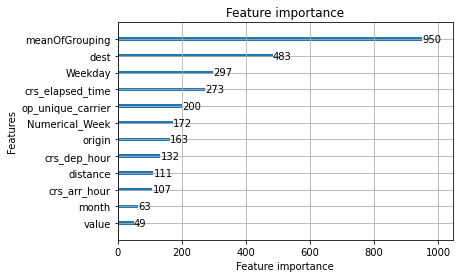

In [48]:
lightgbm.plot_importance(model)

In [49]:
import pandas as pd
import psycopg2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [50]:
con = psycopg2.connect(
    host = 'mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com',
    database='mid_term_project',
    user = 'lhl_student',
    password = 'lhl_student',
    port = 5432
)

In [51]:
cur = con.cursor()

In [52]:
sql = "select * from flights_test;"
dat = pd.read_sql_query(sql, con)

In [53]:
dat['crs_arr_hour'] =dat['crs_arr_time'].astype(str).str[:2].astype(int)

In [54]:
dat['Numerical_Week']= (pd.to_datetime(dat['fl_date']).dt.weekofyear)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [55]:
dat['crs_dep_time'] = dat['crs_dep_time'].astype(float).astype(int).apply(lambda x: '{0:0>4}'.format(x)).astype(str)
dat['crs_dep_hour'] = dat['crs_dep_time'].astype(str).str[:2].astype(int)

In [56]:
weatherdf['fl_date'] = pd.to_datetime(weatherdf['fl_date'])

In [57]:
dat.dtypes

fl_date               datetime64[ns]
mkt_unique_carrier            object
branded_code_share            object
mkt_carrier                   object
mkt_carrier_fl_num             int64
op_unique_carrier             object
tail_num                      object
op_carrier_fl_num              int64
origin_airport_id              int64
origin                        object
origin_city_name              object
dest_airport_id                int64
dest                          object
dest_city_name                object
crs_dep_time                  object
crs_arr_time                   int64
dup                           object
crs_elapsed_time               int64
flights                        int64
distance                       int64
crs_arr_hour                   int64
Numerical_Week                 int64
crs_dep_hour                   int64
dtype: object

In [60]:
dat['month'] = (pd.to_datetime(dat['fl_date']).dt.month)

In [61]:
dat['Weekday'] = pd.to_datetime(dat['fl_date']).dt.dayofweek

In [75]:
dat

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,crs_arr_hour,Numerical_Week,crs_dep_hour,month,Weekday
0,2020-01-01,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363,19,1,18,1,2
1,2020-01-01,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363,13,1,11,1,2
2,2020-01-01,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333,21,1,20,1,2
3,2020-01-01,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333,14,1,13,1,2
4,2020-01-01,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",0915,1035,N,80,1,333,10,1,9,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660551,2020-01-31,DL,DL_CODESHARE,DL,4954,9E,N926XJ,4954,11278,DCA,"Washington, DC",11193,CVG,"Cincinnati, OH",1859,2041,N,102,1,411,20,5,18,1,4
660552,2020-01-31,DL,DL_CODESHARE,DL,4955,9E,N309PQ,4955,11278,DCA,"Washington, DC",11193,CVG,"Cincinnati, OH",1515,1702,N,107,1,411,17,5,15,1,4
660553,2020-01-31,DL,DL_CODESHARE,DL,4956,9E,N324PQ,4956,12478,JFK,"New York, NY",10785,BTV,"Burlington, VT",2205,2337,N,92,1,266,23,5,22,1,4
660554,2020-01-31,DL,DL_CODESHARE,DL,4957,9E,N132EV,4957,13930,ORD,"Chicago, IL",12478,JFK,"New York, NY",1035,1356,N,141,1,740,13,5,10,1,4


In [68]:
dat[['op_unique_carrier','origin','dest','crs_elapsed_time','distance','month','crs_arr_hour','crs_dep_hour','Numerical_Week','Weekday']]

,op_unique_carrier,origin,dest,crs_elapsed_time,distance,month,crs_arr_hour,crs_dep_hour,Numerical_Week,Weekday
0,WN,ONT,SFO,95,363,1,19,18,1,2
1,WN,ONT,SFO,90,363,1,13,11,1,2
2,WN,ONT,SJC,70,333,1,21,20,1,2
3,WN,ONT,SJC,75,333,1,14,13,1,2
4,WN,ONT,SJC,80,333,1,10,9,1,2
...,...,...,...,...,...,...,...,...,...,...
660551,9E,DCA,CVG,102,411,1,20,18,5,4
660552,9E,DCA,CVG,107,411,1,17,15,5,4
660553,9E,JFK,BTV,92,266,1,23,22,5,4
660554,9E,ORD,JFK,141,740,1,13,10,5,4


In [69]:
mergeToTest

,origin,dest,Numerical_Week,crs_arr_hour,meanOfGrouping
0,ORD,BOS,10,23,9.750000
1,ORD,DLH,10,22,0.000000
2,ORD,DBQ,10,21,0.000000
3,ORD,DFW,10,22,0.000000
4,ORD,LGA,10,21,14.714286
...,...,...,...,...,...
588122,BOS,SFO,19,10,5.000000
588123,BOS,ATL,19,15,0.000000
588124,LGA,FLL,1,10,0.000000
588125,LGA,BOS,12,10,0.000000


In [70]:
dat[['op_unique_carrier','origin','dest','crs_elapsed_time','distance','month','crs_arr_hour','crs_dep_hour','Numerical_Week','Weekday']].merge(mergeToTest,on=['origin','dest','Numerical_Week','crs_arr_hour'])

,op_unique_carrier,origin,dest,crs_elapsed_time,distance,month,crs_arr_hour,crs_dep_hour,Numerical_Week,Weekday,meanOfGrouping
0,WN,PHX,ABQ,65,328,1,17,16,1,2,53.000000
1,WN,PHX,ABQ,65,328,1,17,16,1,2,53.000000
2,WN,PHX,ABQ,65,328,1,17,16,1,2,53.000000
3,WN,PHX,ABQ,70,328,1,17,16,1,3,53.000000
4,WN,PHX,ABQ,70,328,1,17,16,1,3,53.000000
...,...,...,...,...,...,...,...,...,...,...,...
253939,EV,ORD,TYS,100,475,1,23,21,5,4,26.000000
253940,AA,MCO,PHX,293,1849,1,13,10,5,4,0.000000
253941,OO,LAX,MRY,77,266,1,21,20,5,4,71.333333
253942,OO,LAX,MRY,77,266,1,21,20,5,4,71.333333
